<a href="https://colab.research.google.com/github/nilakshi104/Classifying-name-with-character-level-RNN/blob/master/Generating_names_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function,division
from io import open
import os
import glob
import unicodedata
import string
import torch
import torch.nn as nn

In [2]:
all_letters=string.ascii_letters+" .,;'-"
n_letters=len(all_letters)
all_letters[57]

'-'

In [3]:
#turn a unicode string to plain ASCII 
def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD',s)
      if unicodedata.category(c) != 'Mn'
      and c in all_letters
  )

#Read a file and split into lines 
#we cant directly store unicode to system so we need to decode it
def readLines(filename):
  lines=open(filename,encoding='utf-8').read().strip().split('\n')
  return [unicodeToAscii(line) for line in lines]

category_lines = {}
all_categories = []
for filename in glob.glob('/content/drive/My Drive/data/character level RNN/data/names/*.txt'):
  category = filename.split('/')[-1].split('.')[0]
  all_categories.append(category)
  lines = readLines(filename)
  category_lines[category] = lines

n_categories=len(all_categories)


print(unicodeToAscii("O'NéàlѼla"))

O'Nealla


In [4]:
glob.glob('/content/drive/My Drive/data/character level RNN/data/names/*.txt')  #prints whole address
print('_________________________')
os.listdir('/content/drive/My Drive/data/character level RNN/data/names/')  #prints only name of folders in it 

_________________________


['French.txt',
 'Chinese.txt',
 'Irish.txt',
 'Spanish.txt',
 'English.txt',
 'Scottish.txt',
 'Czech.txt',
 'Italian.txt',
 'Polish.txt',
 'Russian.txt',
 'Japanese.txt',
 'Portuguese.txt',
 'German.txt',
 'Greek.txt',
 'Korean.txt',
 'Vietnamese.txt',
 'Arabic.txt',
 'Dutch.txt']

In [5]:
class RNN(nn.Module):
  def __init__(self,category_size,input_size,hidden_size,output_size):
    super(RNN,self).__init__()
    self.hidden_size=hidden_size
    self.i2o=nn.Linear(category_size+input_size+hidden_size,output_size)
    self.i2h=nn.Linear(category_size+input_size+hidden_size,hidden_size)
    self.o2o=nn.Linear(output_size+hidden_size,input_size)
    self.dropout=nn.Dropout(0.1)
    self.softmax=nn.LogSoftmax(dim=1)

  def forward(self,category,input,hidden):
    combined=torch.cat((category,input,hidden),1)
    output1=self.i2o(combined)
    hidden=self.i2h(combined)
    out_combined=torch.cat((output1,hidden),1)
    output2=self.o2o(out_combined)
    dropout=self.dropout(output2)
    output=self.softmax(dropout)
    return output,hidden

  def initHidden(self):
    return torch.zeros(1,self.hidden_size)



rnn=RNN(n_categories,n_letters,128,n_letters)

In [6]:
import random

def randomChoice(l):
  return l[random.randint(0,len(l)-1)]

def randomTrainingPair():
  category=randomChoice(all_categories)
  line=randomChoice(category_lines[category])
  return category,line

def categoryTensor(category):
  li=all_categories.index(category)
  tensor=torch.zeros(1,n_categories)
  tensor[0][li]=1
  return tensor

#CONSIDER IF INPUT IS 'Company' then input:is one hot codded rep of 'Company' and output contains index of word 'ompany' and <EOS> (here <EOS> is denoted by - so included '-' in last)

def inputTensor (line):
  tensor=torch.zeros(len(line),n_letters)
  for li,letter in enumerate(line):
    tensor[li,all_letters.find(letter)]=1
  return tensor

def targetTensor(line):
  letter_indexes=[all_letters.find(line[li]) for li in range(1,len(line))]
  letter_indexes.append(n_letters-1)
  return torch.LongTensor(letter_indexes).unsqueeze(1)

#Make category,input and target tensors from a random category,line pair
def randomTrainingExample():
  category,line=randomTrainingPair()
  category_tensor=categoryTensor(category)
  input_line_tensor=inputTensor(line)
  target_line_tensor=targetTensor(line)
  return category_tensor,input_line_tensor,target_line_tensor


In [7]:
targetTensor('dkdbcdsvc').size()

torch.Size([9, 1])

(0 0%) 4
(5000 5%) 2
(10000 10%) 2
(15000 15%) 3
(20000 20%) 3
(25000 25%) 2
(30000 30%) 2
(35000 35%) 2
(40000 40%) 2
(45000 45%) 1
(50000 50%) 0
(55000 55%) 2
(60000 60%) 1
(65000 65%) 2
(70000 70%) 2
(75000 75%) 1
(80000 80%) 2
(85000 85%) 2
(90000 90%) 2
(95000 95%) 3


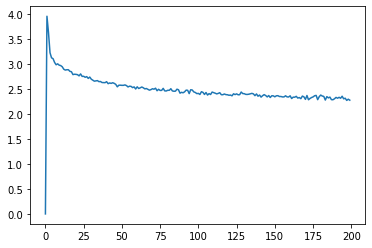

In [8]:
criterion=nn.NLLLoss()
learning_rate=0.0005
n_iters=100000

print_every=5000
plot_every=500


losses=[]
total_loss=0
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
for iter in range(n_iters):
  
  loss=0
  hidden=rnn.initHidden()
  rnn.zero_grad()
  category_tensor,input_line_tensor,target_line_tensor=randomTrainingExample()
  for i in range(input_line_tensor.size(0)):
    output,hidden=rnn(category_tensor,input_line_tensor[i].unsqueeze(0),hidden)
    loss +=criterion(output,target_line_tensor[i])
  total_loss+=loss/input_line_tensor.size(0)
  loss.backward()
  for p in rnn.parameters():
    p.data.add_(p.grad.data,alpha=-learning_rate)

  if iter % print_every==0:
    print('(%d %d%%) %d'%(iter,iter/n_iters*100,loss/input_line_tensor.size(0)))

  if iter % plot_every ==0:
    losses.append(total_loss/plot_every)
    total_loss=0
    
plt.figure()
plt.plot(losses)

  



If we just want to predict word ,no need of category_tensor.As here we want to predict words in every language so extra category_tensor is provided to distinguish between words of different origin

In [11]:
max_length=20

#sample from category and starting_letter
def sample(category,start_letter='A'):
  with torch.no_grad():
    category_tensor=categoryTensor(category)
    input=inputTensor(start_letter)
    hidden=rnn.initHidden()

    output_name=start_letter

    for i in range(max_length):
      output,hidden=rnn(category_tensor,input[0].unsqueeze(0),hidden)
      topv,topi=output.topk(1)            #topv=top_probability,topi=indices
      topi=topi[0][0]
      if topi==n_letters-1:
        break
      else:
        letter=all_letters[topi]
        output_name+=letter
      input=inputTensor(letter)

    return output_name

#get multiple samples from one catgory and multiple satrting letters
def samples(category,start_letters='ABC'):
  for start_letter in start_letters:
    print(sample(category,start_letter))
  

samples('Russian','RUS')


Rovakov
Uarinov
Sharavak


In [12]:
samples('German','GER')

Gello
Eerran
Rongel


In [13]:
samples('Spanish','SPA')

Soner
Para
Arana


In [14]:
samples('Chinese','CHI')

Cha
Ha
Iu


In [20]:
samples('English','PJW')

Panter
Jander
Wanter


In [35]:
letter_new=string.ascii_letters
letter_new

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [40]:
wd=1e-7
lr=0.0005
from torch.optim.lr_scheduler import MultiStepLR
import torch.optim as optim

model=RNN(n_categories,n_letters,128,n_letters)
optimizer = optim.Adam(model.parameters(),
                       lr=lr,
                       weight_decay=wd,
                       betas = (0.9, 0.99),
                       eps = 1e-06)

scheduler = MultiStepLR(optimizer, milestones=[30, 50], gamma=0.1)

class Trainer(object):
  def __init__(self,model,n_iters,criterion,optimizer,scheduler):
    super(Trainer,self).__init__()
    self.model=model
    self.n_iters=n_iters
    self.criterion=criterion
    self.optimizer=optimizer
    self.scheduler=scheduler

  def train(self):
    print_every=5000
    plot_every=500
    losses=[]
    total_loss=0
    for iter in range(self.n_iters):
      loss=0
      self.model.train()
      hidden=self.model.initHidden()
      self.optimizer.zero_grad()
      category_tensor,input_line_tensor,target_line_tensor=randomTrainingExample()
      for i in range(input_line_tensor.size(0)):
        output,hidden=rnn(category_tensor,input_line_tensor[i].unsqueeze(0),hidden)
        loss +=criterion(output,target_line_tensor[i])
      total_loss+=loss/input_line_tensor.size(0)
      loss.backward()
      # for p in rnn.parameters():
      #   p.data.add_(p.grad.data,alpha=-learning_rate)
      self.optimizer.step()
      self.scheduler.step()
      if iter % print_every==0:
        print('(%d %d%%) %d'%(iter,iter/n_iters*100,loss/input_line_tensor.size(0)))
        self.model.eval()
        category=randomChoice(all_categories)
        j=''
        for i in range(3):
          j+=randomChoice(letter_new)
        print('______________')
        print(category+':')
        samples(category,j)
        print('______________')

      if iter % plot_every ==0:
        losses.append(total_loss/plot_every)
        total_loss=0

      
    plt.figure()
    plt.plot(losses)

  
      



(0 0%) 2
______________
Vietnamese:
fan
van
Chan
______________
(5000 5%) 2
______________
Spanish:
eran
erara
tanera
______________
(10000 10%) 2
______________
Italian:
barich
farichi
pongilon
______________
(15000 15%) 2
______________
English:
Ronger
Panter
rander
______________
(20000 20%) 2
______________
Irish:
xangan
vanghan
Iangal
______________
(25000 25%) 1
______________
Portuguese:
Lares
Wares
Danger
______________
(30000 30%) 1
______________
Portuguese:
Nara
jares
noser
______________
(35000 35%) 2
______________
Scottish:
Zangers
Ollon
xandon
______________
(40000 40%) 2
______________
Japanese:
chamama
waki
Uaka
______________
(45000 45%) 2
______________
Portuguese:
Derra
iras
Kares
______________
(50000 50%) 3
______________
Portuguese:
ganer
hares
jares
______________
(55000 55%) 2
______________
English:
oron
wander
Yandel
______________
(60000 60%) 2
______________
Czech:
Lako
Gorak
karaka
______________
(65000 65%) 1
______________
Greek:
daras
tanis
Hantos
_____

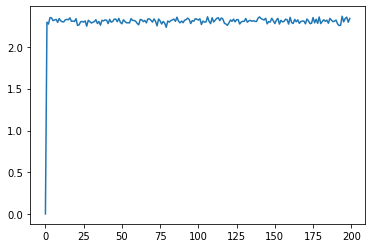

In [41]:
trainer = Trainer(model,
                  n_iters,
                  criterion,
                  optimizer,
                  scheduler)
trainer.train()